In [1]:
import os, math
from collections import defaultdict, namedtuple, deque
import dataclasses
from dataclasses import dataclass
import itertools
from enum import StrEnum, auto
import sqlite3
import logging
import logging.handlers
import pickle
import datetime
import multiprocessing as mp

from PIL import Image, ImageDraw
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy
import numpy as np
import cupy as cp
import pandas as pd

from utils import *
from hdc import *

In [2]:
LOG = Logging()

config_var = 'SQLITE3_SEQ_GRID_0_4096'
config = Config(config_var)
RNG = np.random.default_rng()

if cp.cuda.is_available():
    xp = cp.get_array_module(cp.empty(1))
    xp_array_from_gpu = lambda a: a.get() if isinstance(a, cp.ndarray) else a
    xp_array_to_gpu = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
    xp_array_to_gpu_copy = lambda a: cp.asarray(a) if isinstance(a, np.ndarray) else a
else:
    xp = cp.get_array_module(np.empty(1))
    xp_array_from_gpu = lambda a: a
    xp_array_to_gpu = lambda a: a
    xp_array_to_gpu_copy = lambda a: a.copy()
    
print(f'xp = {xp.__name__}')

def get_full_db_file_name(db_file_name):
    return os.path.join(config.dataset_path, config.db_file_name_prefix + db_file_name)

train_db_con = sqlite3.connect(get_full_db_file_name(config.train_db_file_name))
test_db_con = sqlite3.connect(get_full_db_file_name(config.test_db_file_name))

mp_ctx = mp.get_context('spawn') # req-d for CUPY to work, fork method leads to failures in bootstrap somewhere around CUDA

xp = numpy


In [3]:
%run sequencing_sp.ipynb

In [4]:
DF_TEST_RESULTS = pd.DataFrame(columns=['test_run_id', 'config_variant', 'cortical_columns', 'train_images_count', 'train_runs',
                                        'source_ds', 'test_image_id', 'true_value', 'infer_value', 'match_tab_index', 'match_score'])
TRAIN_RUN_ID = 0
TEST_RUN_ID = 0

In [5]:
hdc = Hdc(10_000, xp)

In [6]:
%time
df_train_images = pd.read_sql_query('SELECT * FROM images', con=train_db_con, index_col='image_id')
df_test_images = pd.read_sql_query('SELECT * FROM images', con=test_db_con, index_col='image_id')
df_train_images.shape, df_test_images.shape

CPU times: user 3 μs, sys: 0 ns, total: 3 μs
Wall time: 4.77 μs


((1000, 5), (200, 5))


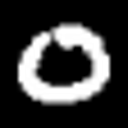
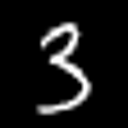
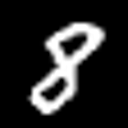
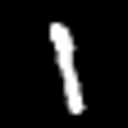
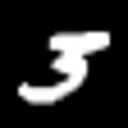
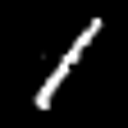
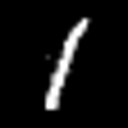
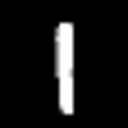
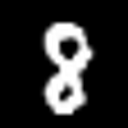
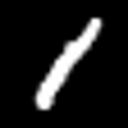
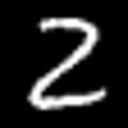
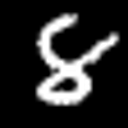
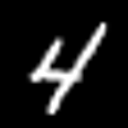
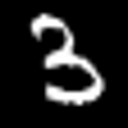
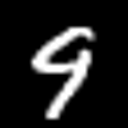
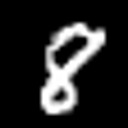

In [7]:
count = 8

def get_images_and_labels(df, ids):
    image_datas = df.loc[ids]['png']
    images = [Image.open(io.BytesIO(image_data)) for image_data in image_datas]
    labels = df.loc[ids]['value']
    return images, list(labels)

def get_some_random_images_and_labels(df, count):
    image_ids = RNG.choice(df.index.unique(), count, replace=False)
    return get_images_and_labels(df, image_ids)

train_images, train_labels = get_some_random_images_and_labels(df_train_images, count)
test_images, test_labels = get_some_random_images_and_labels(df_test_images, count)

display_images_grid(train_images + test_images, captions=train_labels + test_labels, col_count=count)

In [8]:
COS_SIM_45 = np.sqrt(2) / 2
COS_SIM_30 = np.sqrt(3) / 2

In [9]:
HOOK_HISTORY_LEN = 5
HOOK_LV_LEN = (1 + HOOK_HISTORY_LEN) * 4

In [72]:
def _calc_connection_vector(si_ind_from, si_ind_to, sensor_instance_ind_dict):
    si_from = sensor_instance_ind_dict[si_ind_from]
    si_to = sensor_instance_ind_dict[si_ind_to]
    return np.array([si_to.x - si_from.x, si_to.y - si_from.y])

def _calc_normal_vector(si_ind, sensor_instance_ind_dict):
    si = sensor_instance_ind_dict[si_ind]
    return np.array([si.normal_vec.real, si.normal_vec.imag])

# connection vector is ingress by nature, i.e. it describes vector which _ENTERS_ given si_ind during CW tracing
def calc_si_connection_vectors(sequences, sensor_instance_ind_dict):
    connection_vectors_list = []
    
    for seq in sequences:
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        cv = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        cv = np.array(cv)
        connection_vectors_list.append(cv)

    return connection_vectors_list

def calc_si_latent_vectors(sequences, sensor_instance_ind_dict):
    sensor_instance_ind_to_latent_vector = {}
    
    for seq in sequences:
        normal_vectors = list(map(lambda si_ind: _calc_normal_vector(si_ind, sensor_instance_ind_dict), seq))
        
        seq_pairs = zip(seq[-1:] + seq[:-1], seq)
        connection_vectors = list(map(lambda si_inds: _calc_connection_vector(si_inds[0], si_inds[1], sensor_instance_ind_dict), seq_pairs))
        connection_vectors = np.array(connection_vectors)
        connection_vectors = (connection_vectors.T / np.linalg.norm(connection_vectors, axis=1)).T
        
        neighbours_count_for_seq = min(HOOK_HISTORY_LEN, len(seq) - 1)
        
        # look-behind
        pre_vecs = deque()

        for i, si_ind in enumerate(seq[-neighbours_count_for_seq:]):
            normal_vector = normal_vectors[-neighbours_count_for_seq+i]
            connection_vector = connection_vectors[-neighbours_count_for_seq+i]
            pre_vecs.appendleft(np.hstack([normal_vector, connection_vector]))

        # look-ahead
        # post_vecs = deque()

        # for i, si_ind in enumerate(seq[1:1+neighbours_count_for_seq]):
        #     normal_vector = normal_vectors[i]
        #     connection_vector = connection_vectors[i]
        #     post_vecs.append(np.hstack([normal_vector, connection_vector]))

        # i_for_last_post = 0 + neighbours_count_for_seq
        # assert len(pre_vecs) == len(post_vecs)
        pads = [np.array([0, 0, 0, 0])] * (HOOK_HISTORY_LEN - neighbours_count_for_seq)
        
        for i, si_ind in enumerate(seq):
            # print(f'{i} {si_ind}')
            # print(f'{i} {si_ind} {connection_vectors[i]}')
            # print(f'{i} {si_ind} {pre_vecs}')
            latent_vector = []

            latent_vector_head = np.hstack([normal_vectors[i], connection_vectors[i]])
            latent_vector.append(latent_vector_head)
            latent_vector.append(np.array(list(pre_vecs) + pads).ravel())
            # latent_vector.append(np.array(list(post_vecs) + pads).ravel())
            
            latent_vector = np.hstack(latent_vector)
            # print(f'{i} {si_ind} {latent_vector}')
            assert latent_vector.shape == (HOOK_LV_LEN,), latent_vector.shape
            latent_vector = latent_vector / np.linalg.norm(latent_vector)
            sensor_instance_ind_to_latent_vector[si_ind] = latent_vector
    
            pre_vecs.pop()
            pre_vecs.appendleft(latent_vector_head)
            assert len(pre_vecs) == neighbours_count_for_seq

            # post_vecs.popleft()
            # i_for_last_post += 1
            # i_for_last_post = 0 if i_for_last_post >= len(seq) else i_for_last_post
            # post_vecs.append(np.hstack([normal_vectors[i_for_last_post], connection_vectors[i_for_last_post]]))
            # assert len(post_vecs) == neighbours_count_for_seq
        
    return sensor_instance_ind_to_latent_vector

def calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict):
    connection_vectors = np.roll(connection_vectors, -1, axis=0) #  align connection vectors with seq in an egress fashion
    connection_vector_lengths = np.linalg.norm(connection_vectors, axis=1)
    seq_path_length = connection_vector_lengths.sum()
    seq_lv = np.zeros(1000, dtype='F')
    k = seq_lv.shape[0] / seq_path_length
    i = 0
    si_ind_to_offset = {}

    # Build sequence latent vector from a fixed number of normals - stretched or shrinked version of sequences as normals
    # Note. Here connection vectors are egress (describe OUT vector for given si_ind)
    for si_ind, con_vec, con_vec_len in zip(seq, connection_vectors, connection_vector_lengths):
        i_from = int(i)
        i += con_vec_len * k
        i_to = min(int(i), seq_lv.shape[0] - 1)
        assert i_from >= 0, i_from
        assert i_to >= i_from, (i_to, i_from)
        assert i_to < seq_lv.shape[0], (i_to, seq_lv.shape[0])

        normal_vec = sensor_instance_ind_dict[si_ind].normal_vec
        con_vec_normal_vec = complex(con_vec[1], -con_vec[0])

        if (con_vec_normal_vec.real * normal_vec.real + con_vec_normal_vec.imag * normal_vec.imag) < 0:
            con_vec_normal_vec = complex(-con_vec[1], con_vec[0])
        
        assert (con_vec_normal_vec.real * normal_vec.real + con_vec_normal_vec.imag * normal_vec.imag) > 0, (con_vec_normal_vec, con_vec, normal_vec)
        seq_lv[i_from:i_to] = con_vec_normal_vec
        si_ind_to_offset[si_ind] = i_from

        if i_to == seq_lv.shape[0] - 1:
            break

    return seq_lv, si_ind_to_offset

# def calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict):
#     connection_vector_lengths = np.linalg.norm(connection_vectors, axis=1)
#     seq_path_length = connection_vector_lengths.sum()
#     seq_lv = np.zeros(1000, dtype='F')
#     k = seq_lv.shape[0] / seq_path_length
#     i = 0
#     si_ind_to_offset = {}

#     # Build sequence latent vector from a fixed number of normals - stretched or shrinked version of sequences as normals
#     for si_ind, con_vec, con_vec_len in zip(seq, connection_vectors, connection_vector_lengths):
#         i_from = int(i)
#         i += con_vec_len * k
#         i_to = min(int(i), seq_lv.shape[0] - 1)
#         assert i_from >= 0, i_from
#         assert i_to >= i_from, (i_to, i_from)
#         assert i_to < seq_lv.shape[0], (i_to, seq_lv.shape[0])
#         seq_lv[i_from:i_to] = sensor_instance_ind_dict[si_ind].normal_vec
#         si_ind_to_offset[si_ind] = i_from

#         if i_to == seq_lv.shape[0] - 1:
#             break

#     return seq_lv, si_ind_to_offset

In [73]:
def render_image(image_id, df_images, image_sz=(600, 600), with_sequences=False, highlight_si_inds=set(), normal_color='red', highlight_color='darkred', lowlight_color='gray'):
    df_image = df_images.loc[image_id]
    image_png = df_image['png']
    image = Image.open(io.BytesIO(image_png))
    image = image.convert('RGB')
    k = image.size[0]
    image = image.resize(image_sz)
    k = image.size[0] / k
    image_draw = ImageDraw.Draw(image)

    if not with_sequences:
        return image
        
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
    sequences_si = [list(map(lambda si_ind: sensor_instance_ind_dict[si_ind], seq)) for seq in sequences]
    
    for seq in sequences_si:
        for si_from, si_to in zip(seq, seq[1:] + seq[:1]):
            pt_from = si_from.x * k, si_from.y * k
            pt_to = si_to.x * k, si_to.y * k
            image_draw.line([pt_from[0], pt_from[1], pt_to[0], pt_to[1]], width=1, fill=normal_color)
            
            color = normal_color

            if highlight_si_inds:
                color = highlight_color if si_from.Index in highlight_si_inds else lowlight_color

            # print(color)
            
            nl = 8 * k
            image_draw.rectangle([pt_from[0]-1, pt_from[1]-1, pt_from[0]+1, pt_from[1]+1], outline=color)
            normal_vec = si_from.normal_vec
            image_draw.line([pt_from[0], pt_from[1], pt_from[0] + normal_vec.real * nl, pt_from[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_from[0] + normal_vec.real * nl*1.2, pt_from[1] + normal_vec.imag * nl*1.2], str(si_from.Index), anchor='mm', fill=color)

            color = normal_color
            
            if highlight_si_inds:
                color = highlight_color if si_to.Index in highlight_si_inds else lowlight_color
    
            image_draw.rectangle([pt_to[0]-1, pt_to[1]-1, pt_to[0]+1, pt_to[1]+1], outline=color)
            normal_vec = si_to.normal_vec
            image_draw.line([pt_to[0], pt_to[1], pt_to[0] + normal_vec.real * nl, pt_to[1] + normal_vec.imag * nl], width=1, fill=color)
            image_draw.text([pt_to[0] + normal_vec.real * nl*1.2, pt_to[1] + normal_vec.imag * nl*1.2], str(si_to.Index), anchor='mm', fill=color)

    return image

In [74]:
SeqLatentVec = namedtuple('SeqLatentVec', 'engram_id seq_index si_ind lv')
Engram = namedtuple('Engram', 'engram_id, image_id value seqs_count seq_lvs')
HOOK_LVS = HdvArray(HOOK_LV_LEN, xp) # all vectors are normalized
SEQ_LV_DICT = {}
ENGRAM_DICT = {}
ENGRAM_ID_SOURCE = itertools.count(1)

In [77]:
%%time

train_runs = 1
count = min(1000, len(df_train_images))

for _ in tqdm(range(train_runs)):
    TRAIN_RUN_ID += 1
    image_ids = RNG.choice(df_train_images.index.unique(), count, replace=False)
    # image_ids = [28977]
    image_ids = [21514]

    for image_id in image_ids:
        df_image = df_train_images.loc[image_id]
        sensor_instance_ind_dict = pickle.loads(df_image['si'])
        sequences_full = pickle.loads(df_image['seq'])
        sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
        sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
        connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
        assert len(connection_vectors_list) == len(sequences)

        engram = Engram(next(ENGRAM_ID_SOURCE), image_id, str(df_image['value']), len(sequences), [])
        ENGRAM_DICT[engram.engram_id] = engram

        for seq_index, (seq, connection_vectors)  in enumerate(zip(sequences, connection_vectors_list)):
            seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
                
            for i, si_ind in enumerate(seq):
                rolled_seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind])
                seq_lv_boxed = SeqLatentVec(engram.engram_id, seq_index, si_ind, rolled_seq_lv)
                engram.seq_lvs.append(seq_lv_boxed)

                lv = sensor_instance_ind_to_latent_vector[si_ind]
                latent_vector_i = HOOK_LVS.lease()
                HOOK_LVS.array_active[latent_vector_i] = lv
                
                SEQ_LV_DICT[latent_vector_i] = seq_lv_boxed                

  0%|          | 0/1 [00:00<?, ?it/s]

AssertionError: (6j, array([-6,  0]), (1+0j))

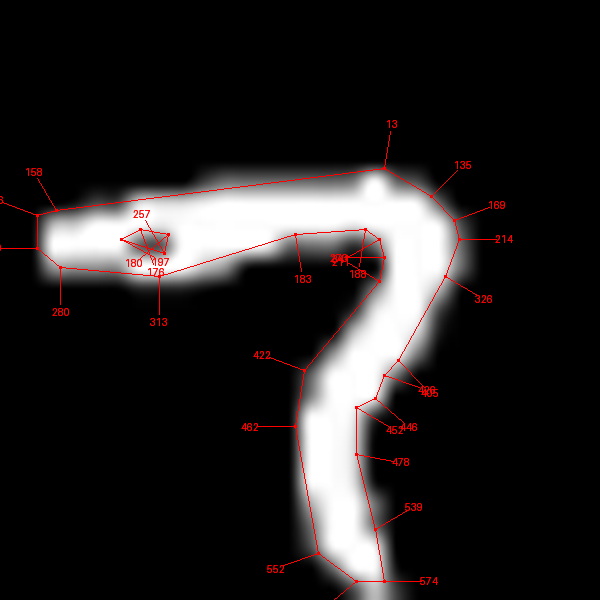

In [82]:
render_image(21514, df_train_images, with_sequences=True)

In [76]:
image_id

np.int64(21514)

In [81]:
sensor_instance_ind_dict[574].normal_vec

(1+0j)

In [79]:
seq

[573,
 552,
 462,
 422,
 341,
 273,
 211,
 188,
 183,
 313,
 280,
 219,
 156,
 158,
 13,
 135,
 169,
 214,
 326,
 405,
 426,
 446,
 452,
 478,
 539,
 574]

In [78]:
connection_vectors

array([[ -6,   0],
       [ -8,  -6],
       [ -5, -27],
       [  2, -12],
       [ 16, -19],
       [  1,  -5],
       [ -1,  -4],
       [ -3,  -2],
       [-15,   1],
       [-29,   9],
       [-21,  -2],
       [ -5,  -4],
       [  0,  -7],
       [  4,  -1],
       [ 70,  -9],
       [ 10,   6],
       [  5,   5],
       [  1,   4],
       [ -3,   8],
       [-10,  18],
       [ -3,   3],
       [ -2,   5],
       [ -4,   2],
       [  0,  10],
       [  4,  16],
       [  2,  11]])

In [ ]:
con_vec_normal_vec = complex(con_vec[1], -con_vec[0])

if (con_vec_normal_vec.real * normal_vec.real + con_vec_normal_vec.imag * normal_vec.imag) < 0:
    con_vec_normal_vec = complex(-con_vec[1], con_vec[0])

assert (con_vec_normal_vec.real * normal_vec.real + con_vec_normal_vec.imag * normal_vec.imag) > 0, (con_vec_normal_vec, con_vec, normal_vec)

In [48]:
a = [11,  0]
b = 1+0j
c = complex(a[1], -a[0])
c, c.real * b.real + c.imag * b.imag

(-11j, 0.0)

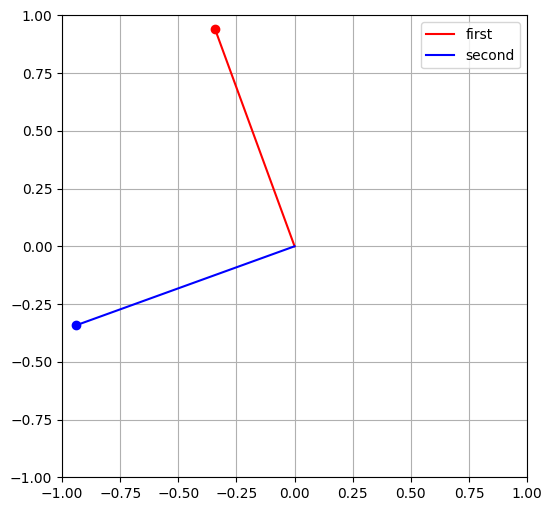

In [29]:
vec1 = [-0.34202014332566855, -0.9396926207859084,  -0.9396926207859084, +0.34202014332566855]
# vec1 = [-0.34202014332566855, -0.9396926207859084,  0.9396926207859084, -0.34202014332566855]

plt.figure(figsize=(6, 6))
plt.plot([0, vec1[0]], [0, -vec1[1]], 'r', label='first')
plt.scatter(vec1[0], -vec1[1], c='r')
plt.plot([0, vec1[2]], [0, -vec1[3]], 'b', label='second')
plt.scatter(vec1[2], -vec1[3], c='b')
plt.ylim(-1, 1)
plt.xlim(-1, 1)
plt.legend()
plt.grid()
plt.show()

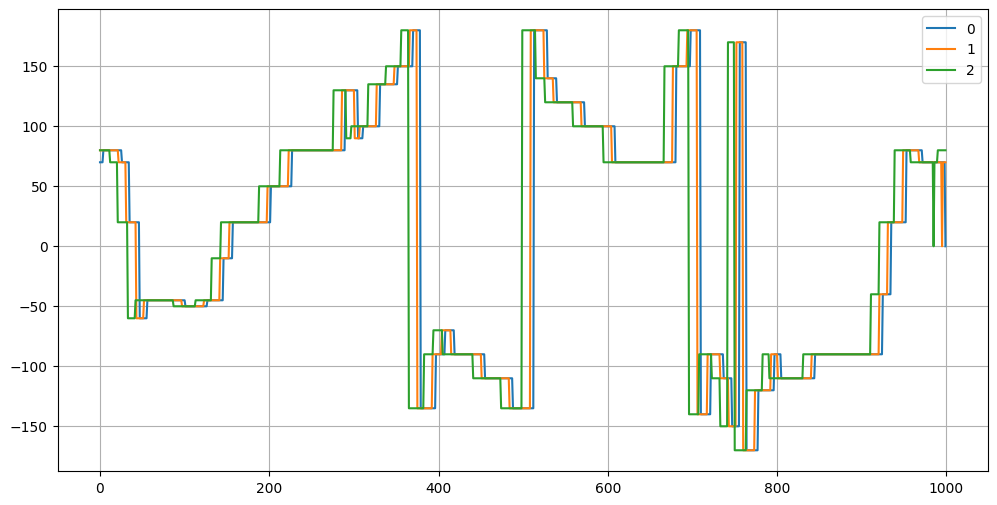

In [213]:
random_engram_id = RNG.choice(list(ENGRAM_DICT.keys()))
seq_lvs = ENGRAM_DICT[random_engram_id].seq_lvs[:3]

plt.figure(figsize=(12, 6))

for i, seq_lv_box in enumerate(seq_lvs):
    plt.plot(np.angle(seq_lv_box.lv, deg=True), label=str(i))
    
plt.grid()
plt.legend()
plt.show()

In [214]:
df_images = df_test_images
image_index = RNG.choice(df_images.index)
image_index = 100001440

df_image = df_images.loc[image_index]
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)

In [215]:
sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
seq_lvs = []

for seq, connection_vectors in zip(sequences, connection_vectors_list):
    seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    seq_lvs.append((seq_lv, si_ind_to_offset))

In [258]:
%%time
engram_to_match_mat = {}
seq_index_to_probe_si_inds = {}
ttt = 0
# Check every sequence of an image under study
for seq_index, seq in enumerate(sequences):
    seq_lv, _ = seq_lvs[seq_index]
    seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

    for i in range(seq_lv.shape[0]):
        seq_lv_phases[i] = seq_lv
        seq_lv = np.roll(seq_lv, +1)
        
    # Explore various hooks - one may be better than other due to different phases of rolled seq_lv
    probe_si_inds = RNG.choice(seq, min(5, len(seq)), replace=False)
    seq_index_to_probe_si_inds[seq_index] = probe_si_inds

    for si_ind in probe_si_inds:
        si_lv = sensor_instance_ind_to_latent_vector[si_ind]
        cos_sims = HOOK_LVS.array_active @ si_lv
        cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
        
        for cos_sim_index in cos_sim_indices:
            candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
            candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
        
            if not candidate_engram.engram_id in engram_to_match_mat:
                engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                
            match_mat = engram_to_match_mat[candidate_engram.engram_id]

            if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
                # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
                continue

            # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
            seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
            seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
            seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
            match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
            ttt += 1
            # match_score = np.sum(np.absolute(seq_lv_diff) ** 2)
            # min_match_score = min(min_match_score, match_score)
            # match_mat[candidate_seq_lv_box.seq_index, seq_index] = min_match_score
                

match_tab = defaultdict(list)

for engram_id, match_mat in engram_to_match_mat.items():
    # Reduce match matrix to vector of least error scores for each column (each sequence of image under study)
    match_vector = np.full(len(sequences), np.inf)
    assert len(sequences) == match_mat.shape[1]
    match_mat_work = match_mat.copy()
    
    for j in range(match_mat_work.shape[1]):
        i = np.argmin(match_mat_work[:,j])
        match_vector[j] = match_mat_work[i,j]
        match_mat_work[:,j] = np.inf
        match_mat_work[i,:] = np.inf
        
    match_tab['image_id'].append(image_index)
    match_tab['value'].append(df_image['value'])

    candidate_engram = ENGRAM_DICT[engram_id]
    match_tab['candidate_engram_id'].append(engram_id)
    match_tab['candidate_image_id'].append(candidate_engram.image_id)
    match_tab['candidate_value'].append(candidate_engram.value)
    match_tab['match_mat'].append(match_mat)
    match_tab['match_vector'].append(match_vector)
    match_tab['match_score'].append(np.sum(match_vector))

df_match_tab = pd.DataFrame(match_tab)
# df_match_tab.sort_values(by=['match_score'], inplace=True)
df_match_tab

CPU times: user 3.97 s, sys: 10.9 ms, total: 3.98 s
Wall time: 1.93 s


,image_id,value,candidate_engram_id,candidate_image_id,candidate_value,match_mat,match_vector,match_score
0,100001440,2,1,32050,6,"[[884.3514404296875], [inf]]",[884.3514404296875],884.351440
1,100001440,2,2,37782,1,[[757.0596313476562]],[757.0596313476562],757.059631
2,100001440,2,3,53181,8,[[743.4956665039062]],[743.4956665039062],743.495667
3,100001440,2,4,22556,5,[[756.135009765625]],[756.135009765625],756.135010
4,100001440,2,5,52036,0,[[823.7235107421875]],[823.7235107421875],823.723511
...,...,...,...,...,...,...,...,...
992,100001440,2,434,2811,1,[[799.673583984375]],[799.673583984375],799.673584
993,100001440,2,704,6845,7,[[962.6597900390625]],[962.6597900390625],962.659790
994,100001440,2,71,37598,1,[[764.3660888671875]],[764.3660888671875],764.366089
995,100001440,2,261,30590,4,[[1105.201904296875]],[1105.201904296875],1105.201904


In [259]:
ttt

1021

In [217]:
def get_activated_hook_si_inds(si_ind, image_id):
    si_lv = sensor_instance_ind_to_latent_vector[si_ind]
    seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
    cos_sims = HOOK_LVS.array_active @ si_lv
    cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
    rv = []
    
    for cos_sim_index in cos_sim_indices:
        candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
        candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

        if candidate_engram.image_id != image_id:
            continue

        rv.append(candidate_seq_lv_box.si_ind)

    return rv


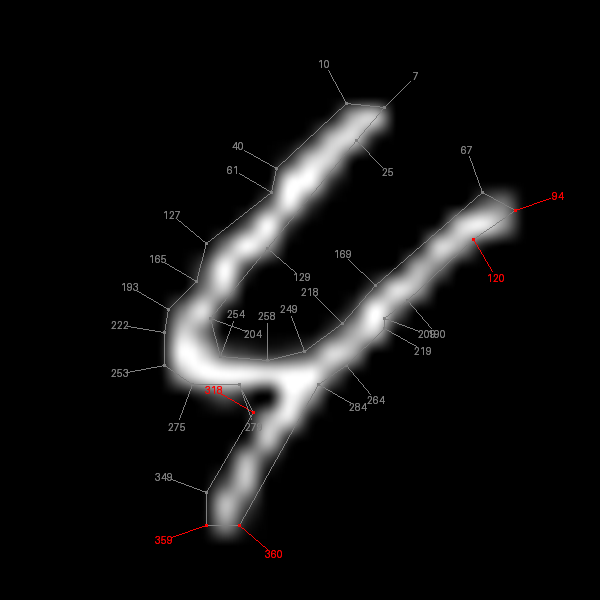
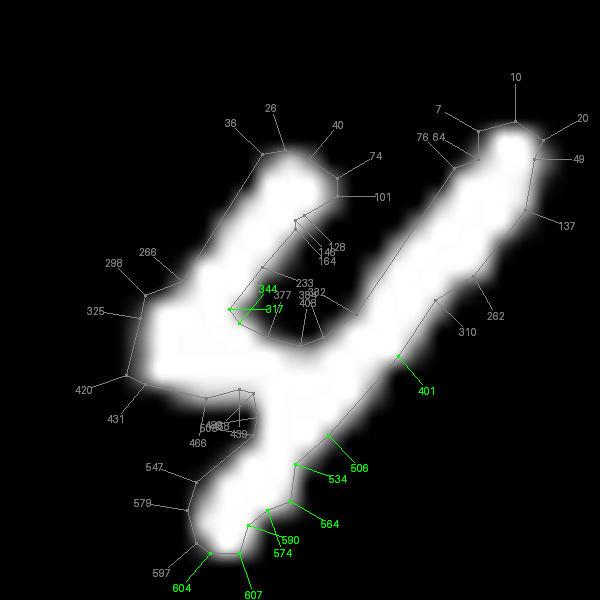

In [218]:
best_candidate_image_id = int(df_match_tab.iloc[0]['candidate_image_id'])
image1 = render_image(image_index, df_test_images,
                      with_sequences=True,
                      highlight_si_inds=list(itertools.chain.from_iterable(seqs_inspection.values())),
                      normal_color='gray', highlight_color='red', lowlight_color='gray')
# image2 = render_image(best_candidate_image_id, df_train_images, 
image2 = render_image(40493, df_train_images, 
                      with_sequences=True,
                      highlight_si_inds=get_activated_hook_si_inds(360, 40493),
                      # highlight_si_inds=set([185]), 
                      normal_color='gray', highlight_color='lime', lowlight_color='gray')
display_images([image1, image2], captions=[f'{image_index}, {df_image['value']}', f'{best_candidate_image_id}'])

In [138]:
zzz = {}

for seq_index, seq in enumerate(sequences):
    seq_lv, si_ind_to_offset = seq_lvs[seq_index]

    for si_ind in [360]:
        si_lv = sensor_instance_ind_to_latent_vector[si_ind]
        seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
        cos_sims = HOOK_LVS.array_active @ si_lv
        cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
        
        for cos_sim_index in cos_sim_indices:
            candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
            candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

            if candidate_engram.image_id == 40493:
                seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
                error_score = np.sum(np.absolute(seq_lv_diff) ** 2)
                zzz[candidate_seq_lv_box.si_ind] = (seq_lv_diff, seq_lv, candidate_seq_lv_box.lv)

In [139]:
zzz.keys()

dict_keys([317, 344, 401, 506, 534, 564, 574, 590, 607, 604])

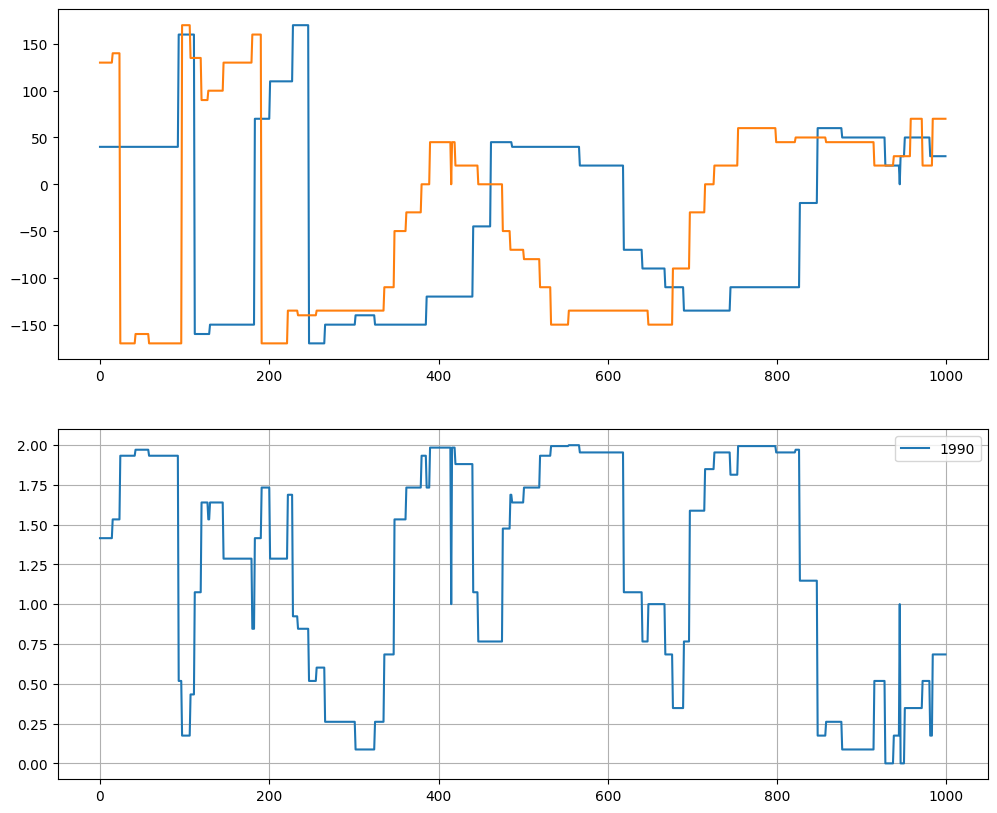

In [150]:
plt.figure(figsize=(12, 10))


# for si_ind in [534]:
for si_ind in [604]:
    plt.subplot(2, 1, 1)
    # plt.plot(np.absolute(zzz[si_ind]), label=f'{si_ind}; {np.sum(np.absolute(zzz[si_ind]) ** 2):.0f}')
    plt.plot(np.angle(zzz[si_ind][1], deg=True), label=f'us')
    plt.plot(np.angle(zzz[si_ind][2], deg=True), label=f'cand')
    plt.subplot(2, 1, 2)
    plt.plot(np.absolute(zzz[si_ind][0]), label=f'{np.sum(np.absolute(zzz[si_ind][0]) ** 2):.0f}')

plt.legend()
plt.grid()
plt.show()

In [219]:
# TEST RUN
TEST_RUN_ID += 1
test_run_source = (df_test_images, test_db_con, 'test')
# test_run_source = (df_train_images, train_db_con, 'train')
count = min(100, len(test_run_source[0]))
test_image_ids = RNG.choice(test_run_source[0].index.unique(), count, replace=False)
# test_image_ids = image_ids
test_result_rows = defaultdict(list)
match_tabs = []

for image_id in tqdm(test_image_ids):
    df_image = test_run_source[0].loc[image_id]
    image_value = df_image['value']
    sensor_instance_ind_dict = pickle.loads(df_image['si'])
    sequences_full = pickle.loads(df_image['seq'])
    sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)    
    sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
    connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
    seq_lvs = []
    
    for seq, connection_vectors in zip(sequences, connection_vectors_list):
        seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
        seq_lvs.append((seq_lv, si_ind_to_offset))

    engram_to_match_mat = {}
    
    # Check every sequence of an image under study
    for seq_index, seq in enumerate(sequences):
        # seq_lv, si_ind_to_offset = seq_lvs[seq_index]
        seq_lv, _ = seq_lvs[seq_index]
        seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

        for i in range(seq_lv.shape[0]):
            seq_lv_phases[i] = seq_lv
            seq_lv = np.roll(seq_lv, +1)
        
        # Explore various hooks - one may be better than other due to different phases of rolled seq_lv
        si_inds = RNG.choice(seq, min(5, len(seq)), replace=False)
    
        for si_ind  in si_inds:
            si_lv = sensor_instance_ind_to_latent_vector[si_ind]
            # seq_lv = np.roll(seq_lv, -si_ind_to_offset[si_ind]) # phasing
            cos_sims = HOOK_LVS.array_active @ si_lv
            cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
            
            for cos_sim_index in cos_sim_indices:
                candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
                candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
            
                if not candidate_engram.engram_id in engram_to_match_mat:
                    engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                    
                match_mat = engram_to_match_mat[candidate_engram.engram_id]
        
                if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
                    # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
                    continue
        
                # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
                seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
                seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
                seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
                match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
                
                # candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
                # candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]
            
                # seq_lv_diff = candidate_seq_lv_box.lv - seq_lv
                # error_score = np.sum(np.absolute(seq_lv_diff) ** 2)
    
                # if not candidate_engram.engram_id in engram_to_match_mat:
                #     engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
    
                # match_mat = engram_to_match_mat[candidate_engram.engram_id]
                # match_mat_score = match_mat[candidate_seq_lv_box.seq_index, seq_index]
    
                # if error_score < match_mat_score:
                #     match_mat[candidate_seq_lv_box.seq_index, seq_index] = error_score
    
    match_tab = defaultdict(list)
    
    for engram_id, match_mat in engram_to_match_mat.items():
        # Reduce match matrix to vector of least error scores for each column (each sequence of image under study)
        match_vector = np.full(len(sequences), np.inf)
        assert len(sequences) == match_mat.shape[1]
        match_mat_work = match_mat.copy()
        
        for j in range(match_mat_work.shape[1]):
            i = np.argmin(match_mat_work[:,j])
            match_vector[j] = match_mat_work[i,j]
            match_mat_work[:,j] = np.inf
            match_mat_work[i,:] = np.inf
            
        candidate_engram = ENGRAM_DICT[engram_id]
        match_tab['candidate_engram_id'].append(engram_id)
        match_tab['candidate_image_id'].append(candidate_engram.image_id)
        match_tab['candidate_value'].append(candidate_engram.value)
        match_tab['match_mat'].append(match_mat)
        match_tab['match_vector'].append(match_vector)
        match_tab['match_score'].append(np.sum(match_vector))

    df_match_tab = pd.DataFrame(match_tab)
    df_match_tab.sort_values(by=['match_score'], inplace=True)
    match_tabs.append(df_match_tab)

    if len(df_match_tab) > 0 and np.isfinite(df_match_tab.iloc[0].match_score):
        infer_value = df_match_tab.iloc[0]['candidate_value']
    else:
        infer_value = ''
    
    test_result_rows['test_run_id'].append(TEST_RUN_ID)
    test_result_rows['config_variant'].append(config.section_name)
    test_result_rows['cortical_columns'].append([])
    test_result_rows['train_images_count'].append(len(ENGRAM_DICT))
    test_result_rows['train_runs'].append(TRAIN_RUN_ID)
    test_result_rows['source_ds'].append(test_run_source[2])
    test_result_rows['test_image_id'].append(image_id)
    test_result_rows['true_value'].append(image_value)
    test_result_rows['infer_value'].append(infer_value)
    test_result_rows['match_score'].append(df_match_tab.iloc[0]['match_score'])
    test_result_rows['match_tab_index'].append(len(match_tabs) - 1)
    

assert set(test_result_rows.keys()) == set(DF_TEST_RESULTS.columns), set(test_result_rows.keys()) ^ set(DF_TEST_RESULTS.columns)
df_test_results_for_run = pd.DataFrame(test_result_rows, columns=DF_TEST_RESULTS.columns)
concat_list = [DF_TEST_RESULTS] if len(DF_TEST_RESULTS) > 0 else []
concat_list.append(df_test_results_for_run)
DF_TEST_RESULTS = pd.concat(concat_list, ignore_index=True)

  0%|          | 0/100 [00:00<?, ?it/s]

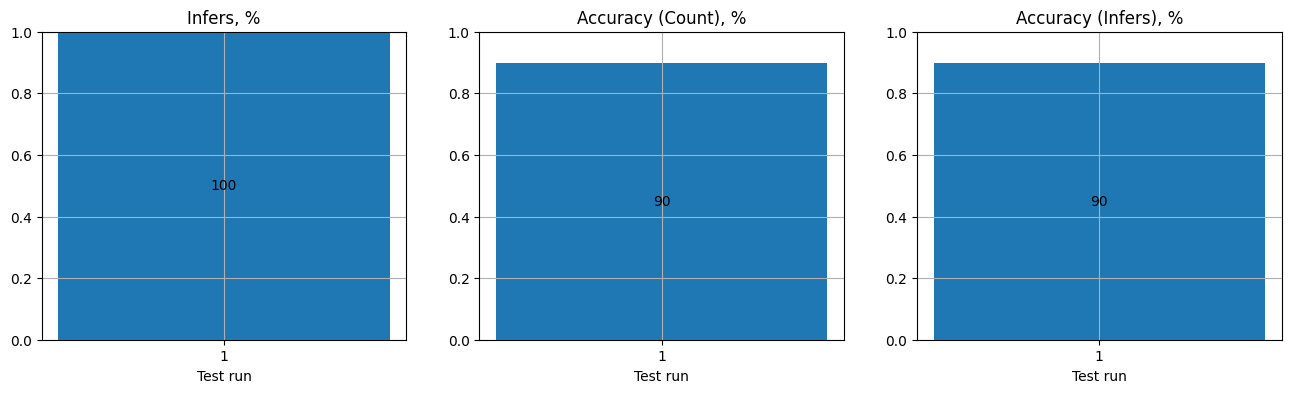

,config_variant,source_ds,cortical_columns,train_images_count,train_runs,count,infers,correct_infers,infer_ratio,accuracy_count,accuracy_infers
test_run_id,,,,,,,,,,,
1,SQLITE3_SEQ_GRID_0_4096,test,[],1000,1,100,100,90,1.0,0.9,0.9


In [220]:
df_test_results2 = DF_TEST_RESULTS.copy()
df_test_results2['is_infer'] = df_test_results2['infer_value'] != ''
df_test_results2['is_correct_infer'] = df_test_results2['true_value'] == df_test_results2['infer_value']
df_test_results2 = df_test_results2.groupby(by=['test_run_id']).agg({'config_variant': 'first', 
                                                                     'source_ds': 'first',
                                                                     'cortical_columns': 'first',
                                                                     'train_images_count': 'first',
                                                                     'train_runs': 'first',
                                                                     'test_image_id': 'count', 
                                                                     'is_infer': 'sum', 
                                                                     'is_correct_infer': 'sum'})
df_test_results2.rename(columns=dict(test_image_id='count', is_infer='infers', is_correct_infer='correct_infers'), inplace=True, errors='raise')
df_test_results2['infer_ratio'] = df_test_results2['infers'] / df_test_results2['count']
df_test_results2['accuracy_count'] = df_test_results2['correct_infers'] / df_test_results2['count']
df_test_results2['accuracy_infers'] = df_test_results2['correct_infers'] / df_test_results2['infers']
df_test_results2['accuracy_infers'] = df_test_results2['accuracy_infers'].fillna(0)

plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['infer_ratio']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['infer_ratio']), label_type='center')
plt.ylim(0, 1)
plt.title('Infers, %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 2)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_count']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_count']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Count), %')
plt.xlabel('Test run')
plt.grid()

plt.subplot(1, 3, 3)
b = plt.bar(list(map(str, df_test_results2.index)), list(df_test_results2['accuracy_infers']))
plt.bar_label(b, map(lambda p: f'{p*100:.0f}', df_test_results2['accuracy_infers']), label_type='center')
plt.ylim(0, 1)
plt.title('Accuracy (Infers), %')
plt.xlabel('Test run')
plt.grid()

plt.show()
df_test_results2

In [221]:
df_last_run_results = DF_TEST_RESULTS[DF_TEST_RESULTS.test_run_id == max(DF_TEST_RESULTS.test_run_id)]
df_incorrect = df_last_run_results.loc[df_last_run_results.true_value != df_last_run_results.infer_value]
df_incorrect

,test_run_id,config_variant,cortical_columns,train_images_count,train_runs,source_ds,test_image_id,true_value,infer_value,match_tab_index,match_score
4,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100008984,7,9,4,868.824066
28,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100006081,9,8,28,764.589203
30,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100009669,4,1,30,889.346649
32,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100007218,4,9,32,548.309326
40,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100004485,7,9,40,255.623779
49,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100009117,5,7,49,510.892853
55,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100001716,7,1,55,303.489227
61,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100006748,1,8,61,200.414948
71,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100000553,8,6,71,789.872513
73,1,SQLITE3_SEQ_GRID_0_4096,[],1000,1,test,100001662,6,0,73,403.793640


In [237]:
df_last_run_results.loc[df_last_run_results.true_value == df_last_run_results.infer_value].match_score.describe()

count     90.000000
mean     440.718709
std      200.341205
min       86.799850
25%      300.713287
50%      402.153198
75%      542.173592
max      897.208832
Name: match_score, dtype: float64

In [239]:
match_tabs[61]

,candidate_engram_id,candidate_image_id,candidate_value,match_mat,match_vector,match_score
75,82,21613,8,"[[200.41494750976562], [inf], [inf]]",[200.41494750976562],200.414948
443,490,28769,1,[[205.95501708984375]],[205.95501708984375],205.955017
324,356,2547,1,[[210.08143615722656]],[210.08143615722656],210.081436
341,375,32041,1,"[[221.18272399902344], [inf]]",[221.18272399902344],221.182724
405,447,12805,1,"[[224.2311553955078], [423.60455322265625], [i...",[224.2311553955078],224.231155
...,...,...,...,...,...,...
317,349,35026,6,"[[1057.3037109375], [inf]]",[1057.3037109375],1057.303711
943,594,15922,7,[[1069.9873046875]],[1069.9873046875],1069.987305
970,850,57280,7,[[1076.869140625]],[1076.869140625],1076.869141
461,512,52144,2,"[[1093.61962890625], [inf]]",[1093.61962890625],1093.619629


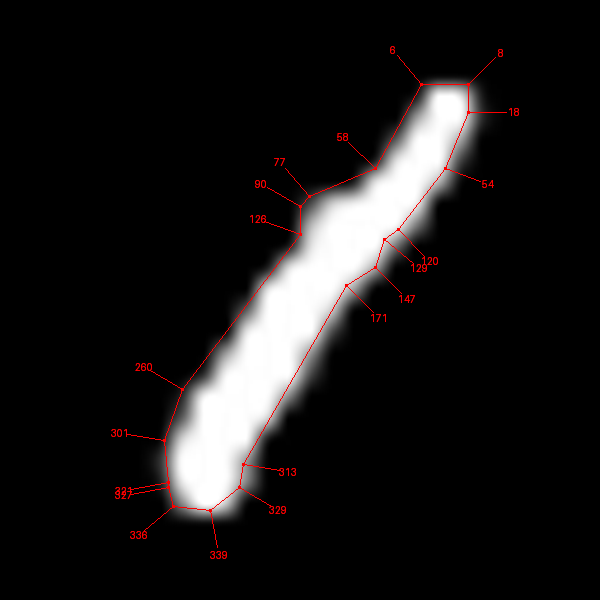

In [238]:
render_image(100006748, df_test_images, with_sequences=True)

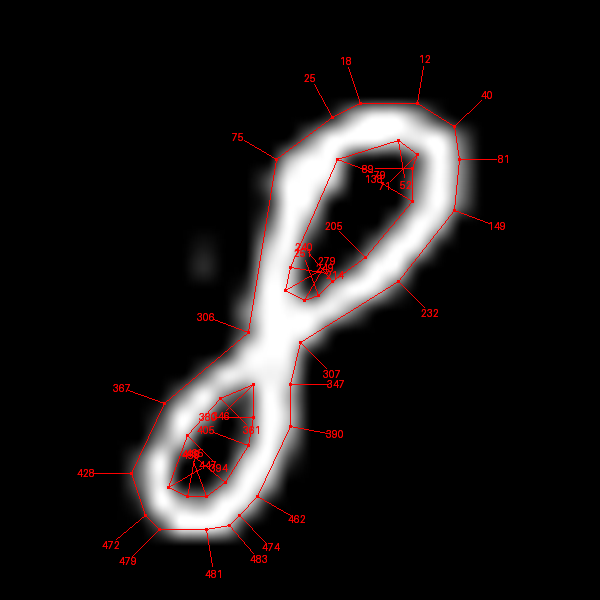

In [240]:
render_image(21613, df_train_images, with_sequences=True)

In [342]:
df_image = test_run_source[0].loc[100006748]
sensor_instance_ind_dict = pickle.loads(df_image['si'])
sequences_full = pickle.loads(df_image['seq'])
sequences = simplify_sequences(sequences_full, sensor_instance_ind_dict)
sensor_instance_ind_to_latent_vector = calc_si_latent_vectors(sequences, sensor_instance_ind_dict)
connection_vectors_list = calc_si_connection_vectors(sequences, sensor_instance_ind_dict)
seq_lvs = []

for seq, connection_vectors in zip(sequences, connection_vectors_list):
    seq_lv, si_ind_to_offset = calc_seq_latent_vector(seq, connection_vectors, sensor_instance_ind_dict)
    seq_lvs.append((seq_lv, si_ind_to_offset))

engram_to_match_mat = {}

# Check every sequence of an image under study
for seq_index, seq in enumerate(sequences):
    # seq_lv, si_ind_to_offset = seq_lvs[seq_index]
    seq_lv, _ = seq_lvs[seq_index]
    seq_lv_phases = np.empty((seq_lv.shape[0], seq_lv.shape[0]), dtype='F')

    for i in range(seq_lv.shape[0]):
        seq_lv_phases[i] = seq_lv
        seq_lv = np.roll(seq_lv, +1)
    
    # Explore various hooks - one may be better than other due to different phases of rolled seq_lv
    si_inds = RNG.choice(seq, min(5, len(seq)), replace=False)

    for si_ind in si_inds:
        si_lv = sensor_instance_ind_to_latent_vector[si_ind]
        cos_sims = HOOK_LVS.array_active @ si_lv
        cos_sim_indices = np.argwhere(cos_sims > COS_SIM_45).ravel()
        
        for cos_sim_index in cos_sim_indices:
            candidate_seq_lv_box = SEQ_LV_DICT[cos_sim_index]
            candidate_engram = ENGRAM_DICT[candidate_seq_lv_box.engram_id]

            if candidate_engram.image_id != 21613:
                continue
        
            if not candidate_engram.engram_id in engram_to_match_mat:
                engram_to_match_mat[candidate_engram.engram_id] = np.full((candidate_engram.seqs_count, len(sequences)), np.inf)
                
            match_mat = engram_to_match_mat[candidate_engram.engram_id]
    
            if np.isfinite(match_mat[candidate_seq_lv_box.seq_index,seq_index]):
                # this relation (candidate_seq_lv_box.seq_index VS seq_index) is already assessed
                continue

            # print(candidate_seq_lv_box.seq_index, seq_index, candidate_seq_lv_box.lv[0])
            # Find best match between seq_lv and candidate_seq_lv_box.lv via thorough phasing
            seq_lv_diffs_mat = candidate_seq_lv_box.lv - seq_lv_phases
            seq_lv_diffs_mat = np.absolute(seq_lv_diffs_mat)
            seq_lv_diffs_vec = np.sum(seq_lv_diffs_mat, axis=1)
            match_mat[candidate_seq_lv_box.seq_index, seq_index] = np.min(seq_lv_diffs_vec)
            assert False

AssertionError: 

In [344]:
np.argmin(seq_lv_diffs_vec)

np.int64(472)

In [345]:
seq_lv_diffs_vec[472]

np.float32(200.41495)

In [346]:
np.absolute(candidate_seq_lv_box.lv - seq_lv_phases[472]).sum()

np.float32(200.41495)

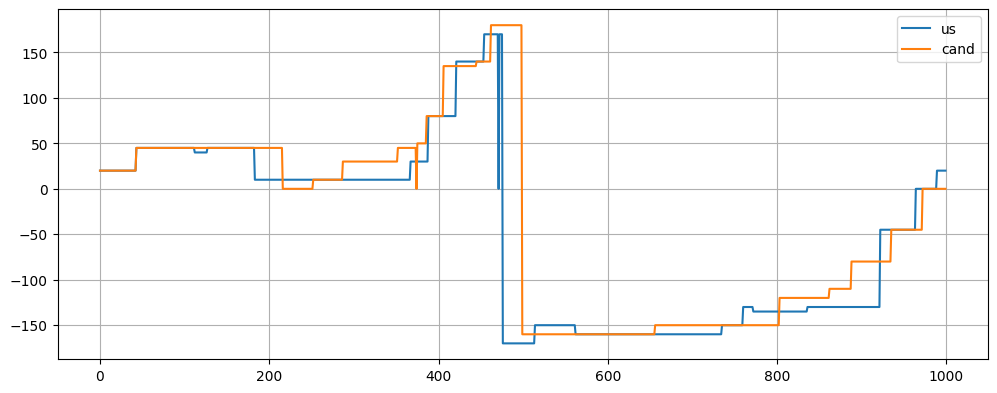

In [347]:
plt.figure(figsize=(12, 10))

plt.subplot(2, 1, 1)
plt.plot(np.angle(seq_lv_phases[472], deg=True), label=f'us')
plt.plot(np.angle(candidate_seq_lv_box.lv, deg=True), label=f'cand')
# plt.subplot(2, 1, 2)
# plt.plot(np.absolute(zzz[si_ind][0]), label=f'{np.sum(np.absolute(zzz[si_ind][0]) ** 2):.0f}')

plt.legend()
plt.grid()
plt.show()